# NIRCam photutils detections

Detecting objects and checking the results. Parameters to play with:

http://github.com/dancoe/ceers

Analyzing simulated NIRCam images from  
CEERS SDR3: Simulated Data Release 3 https://ceers.github.io/sdr3.html   
NIRCam images in 6 filters: F115W F150W F200W F277W F356W F444W  
0.03" / pixel image reductions (native SW ~0.03", LW ~0.06")  

Photutils 1.4 photometry  

Detection image is weighted stack of all filters  
I find this performs better than a single filter F200W detection image:
* deeper (mag ~30 instead of ~29)
* larger apertures to capture more flux in LW images and measure more accurate colors
* fills the SW gaps (not filled by dithers in this program)

This is an updated version of an older JWST Data Analysis [JDAT notebook](https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam_PSF-matched_photometry/NIRCam_PSF_matched_multiband_photometry.html) 
that analyzed JADES JAGUAR simulated images

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

import photutils
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog#, source_properties
from photutils.utils import calc_total_error
print('photutils', photutils.__version__)
from packaging import version
if version.parse(photutils.__version__) < version.parse("1.4.0"):
    print('WARNING photutils not up to date with 1.4: convolution may take forever; also need to tweak error input command below')

from photutils.psf.matching import resize_psf, create_matching_kernel, CosineBellWindow
from astropy.convolution import convolve, convolve_fft # , Gaussian2DKernel, Tophat2DKernel

from scipy import ndimage

photutils 1.4.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.22.4
photutils : 1.4.0
matplotlib: 3.5.2
scipy     : 1.8.1
watermark : 2.3.1
astropy   : 5.1
packaging : 21.3



In [4]:
#image_file = '../images/ceers5_f200w_sci.fits.gz'
image_file = '../images/ceers5_total_sci.fits.gz'
image_hdu_list = fits.open(image_file)
idata = 1  # fits extension where data lives
image_data = image_hdu_list[idata].data
imwcs = wcs.WCS(image_hdu_list[idata].header, image_hdu_list)

In [5]:
data_error_file = image_file.replace('_sci.fits', '_err.fits')
idata_error = 2  # extension of HDU where data_error lives
data_error = fits.open(data_error_file)[idata_error].data
data_error_file

'../images/ceers5_total_err.fits.gz'

In [6]:
#idata_weight = 3 # extension of HDU where data_weight lives

In [7]:
ny, nx = image_data.shape
# image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * image_pixel_scale, nx * image_pixel_scale)
outline += ' (%.2f" / pixel)' % image_pixel_scale
print(outline)

5000 x 10500 pixels = 150" x 315" (0.03" / pixel)


# View images (optional)

<IPython.core.display.Javascript object>


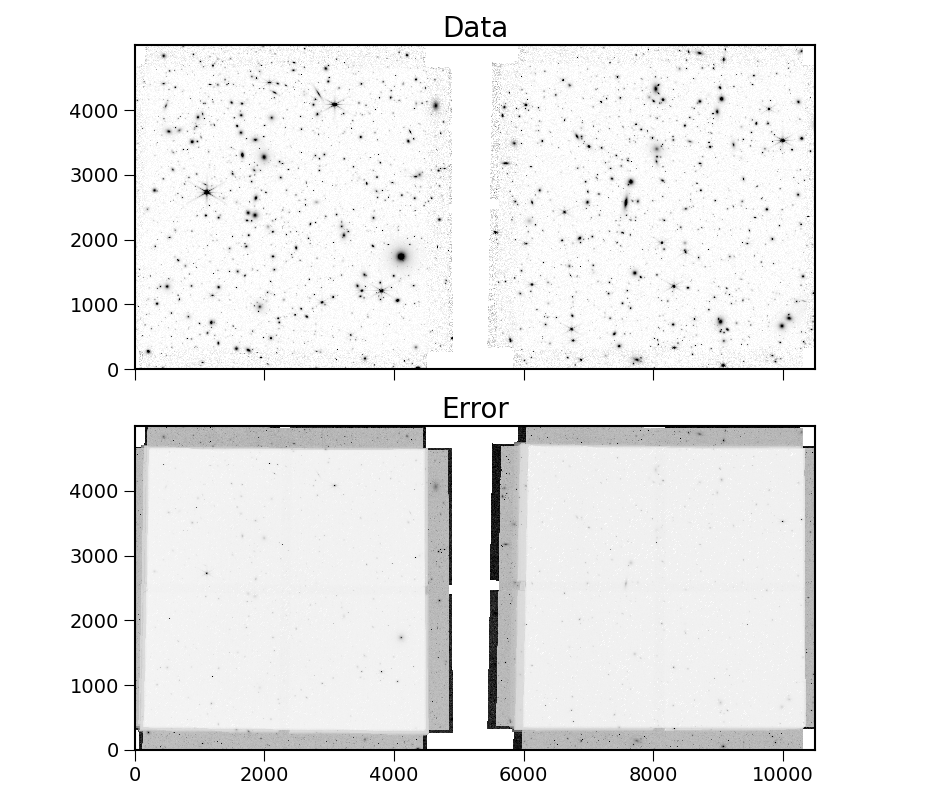

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(9.5, 8), sharex=True, sharey=True)

ax[0].set_title('Data')
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
ax[0].imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')

ax[1].set_title('Error')
norm = simple_norm(data_error, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[1].imshow(data_error, origin='lower', norm=norm, interpolation='none', cmap='Greys')

## Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

JWST data units: MJy / sr  
Mega Janskys (MJy); mag_AB = 8.9 - 2.5 log10(flux_Jy) = 31.4 - 2.5 log10(flux_nJy)  
steradian (sr) is a unit of solid angle: sphere = 4 pi sr = 4 pi (180 deg / pi)^2 = 41253 deg^2 = 2.2e16 arcsec^2

In [11]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

Note magnitude uncertainties for detections should probably be u.mag instead of u.ABmag  
but magnitude uncertainties for non-detections quote u.ABmag upper limits  
They need to be the same, so we go with u.ABmag  

## Detect Sources and Deblend using astropy.photutils (similar to SourceExtractor)
https://photutils.readthedocs.io/en/latest/segmentation.html

In [12]:
# Define all detection and measurement parameters here so that we do measurements consistently for every image

JWST_flux_units = u.MJy / u.sr

# https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog.area
output_properties = 'label xcentroid ycentroid sky_centroid area semimajor_sigma semiminor_sigma'.split()
output_properties += 'fwhm ellipticity orientation gini'.split()
output_properties += 'kron_radius local_background segment_flux segment_fluxerr kron_flux kron_fluxerr'.split()
# columns += 'source_sum source_sum_err kron_flux kron_fluxerr kron_radius local_background'.split()

class Photutils_Catalog:
    def __init__(self, filt, image_file=None, error_file=None, verbose=True, mask_edge_thickness=10):
        self.image_file = image_file or image_files[filt]
        self.hdu = fits.open(self.image_file)
        self.imwcs = wcs.WCS(self.hdu[idata].header, self.hdu)
        self.data       = self.hdu[idata].data  # 'SCI' i2d extension 1
        self.convolved_data = None  # initialize; to be populated later; added in photutils 1.4

        # total error array (i.e., the background-only error plus Poisson noise due to individual sources)
        # https://photutils.readthedocs.io/en/stable/segmentation.html#photometric-errors        
        #self.data_error = self.hdu[2].data  # 'ERR' i2d extension 2
        self.data_error_file = error_file or data_error_files[filt]
        self.data_error = fits.open(self.data_error_file)[idata_error].data
        self.data_mask = np.isnan(self.data_error) # | (model.wht == 0)
        # Remove edge detections: Grow the mask by 10 pixels
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html
        self.data_mask = ndimage.binary_dilation(self.data_mask, iterations=mask_edge_thickness)

        # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
        self.pixel_scale = wcs.utils.proj_plane_pixel_scales(self.imwcs)[0] 
        self.pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
        self.flux_units = JWST_flux_units * (self.pixel_scale * u.arcsec)**2
        #self.zeropoint = self.hdu[0].header['ABMAG'] * u.ABmag 
        #self.zeropoint = 31.4 * u.ABmag # no zeropoint (ABMAG) in the header, add manually, 31.4 for nJy
        if verbose:
            print(self.image_file)
            ny, nx = self.data.shape
            outline = '%d x %d pixels' % (ny, nx)
            outline += ' = %g" x %g"' % (ny * self.pixel_scale, nx * self.pixel_scale)
            outline += ' (%.2f" / pixel)' % self.pixel_scale
            print(outline)
            #print(filt, '  zeropoint =', self.zeropoint)
            #print(self.weight_file)

    def measure_background_map(self, bkg_size=50, filter_size=3, verbose=True):
        # Calculate sigma-clipped background in cells of 50x50 pixels, then median filter over 3x3 cells
        # For best results, the image should span an integer number of cells in both dimensions (e.g., 1000=20x50 pixels)
        # https://photutils.readthedocs.io/en/stable/background.html
        self.background_map = Background2D(self.data, bkg_size, filter_size=filter_size)

    def smooth_data(self, smooth_fwhm=2, kernel_size=5):
        # convolve data with Gaussian 
        # convolved_data used for source detection and to calculate source centroids and morphological properties
        smooth_sigma = smooth_fwhm * gaussian_fwhm_to_sigma
        self.smooth_kernel = Gaussian2DKernel(smooth_sigma, x_size=kernel_size, y_size=kernel_size)
        self.smooth_kernel.normalize()
        self.convolved_data = convolve(self.data, self.smooth_kernel)
        
    def run_detect_sources(self, nsigma, npixels, smooth_fwhm=2, kernel_size=5, 
                           deblend_levels=32, deblend_contrast=0.001, verbose=True):

        # Set detection threshold map as nsigma times RMS above background pedestal
        detection_threshold = (nsigma * self.background_map.background_rms) + self.background_map.background

        # Before detection, convolve data with Gaussian
        self.smooth_data(smooth_fwhm, kernel_size)

        # Detect sources with npixels connected pixels at/above threshold in data smoothed by kernel
        # https://photutils.readthedocs.io/en/stable/segmentation.html
        self.segm_detect = detect_sources(self.data, detection_threshold, npixels=npixels, kernel=self.smooth_kernel)

        # Deblend: separate connected/overlapping sources
        # https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending
        self.segm_deblend = deblend_sources(self.data, self.segm_detect, npixels=npixels, kernel=self.smooth_kernel,
                                            nlevels=deblend_levels, contrast=deblend_contrast)
        if verbose:
            output = 'Cataloged %d objects' % self.segm_deblend.nlabels
            output += ', deblended from %d detections' % self.segm_detect.nlabels
            median_threshold = (nsigma * self.background_map.background_rms_median) \
                + self.background_map.background_median
            output += ' with %d pixels above %g-sigma threshold' % (npixels, nsigma)
            # Background outputs equivalent to those reported by SourceExtractor
            output += '\n'
            output += 'Background median %g' % self.background_map.background_median
            output += ', RMS %g' % self.background_map.background_rms_median
            output += ', threshold median %g' % median_threshold
            print(output)

    def measure_source_properties(self, local_background_width=24, properties=output_properties):
        if version.parse(photutils.__version__) >= version.parse("1.4.0"):
            self.catalog = SourceCatalog(self.data-self.background_map.background, self.segm_deblend,
                                         convolved_data=self.convolved_data,  # photutils 1.4
                                         error=self.data_error, mask=self.data_mask,
                                         background=self.background_map.background, wcs=self.imwcs,
                                         localbkg_width=local_background_width)
        else:  # use filter_kernel instead of convolved_data
            self.catalog = SourceCatalog(self.data-self.background_map.background, self.segm_deblend, 
                                         kernel=self.smooth_kernel,  # photutils < 1.4 
                                         error=self.data_error, mask=self.data_mask,
                                         background=self.background_map.background, wcs=self.imwcs,
                                         localbkg_width=local_background_width)


        self.catalog_table = self.catalog.to_table(columns=properties)  # properties: quantities to keep
        
        # Convert fluxes to nJy units and to AB magnitudes
        for aperture in ['segment', 'kron']:
            flux    = self.catalog_table[aperture+'_flux']    * self.flux_units.to(u.nJy)
            fluxerr = self.catalog_table[aperture+'_fluxerr'] * self.flux_units.to(u.nJy)
            mag, magerr = fluxes2mags(flux, fluxerr)
            
            self.catalog_table[aperture+'_flux']    = flux
            self.catalog_table[aperture+'_fluxerr'] = fluxerr
            self.catalog_table[aperture+'_mag']     = mag
            self.catalog_table[aperture+'_magerr']  = magerr            

In [14]:
detection_filter = 'total'
detection_catalog = Photutils_Catalog(detection_filter, image_file, data_error_file)
detection_catalog.measure_background_map()
detection_catalog.run_detect_sources(nsigma=3, npixels=5)

../images/ceers5_total_sci.fits.gz
5000 x 10500 pixels = 150" x 315" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:242: RuntimeWarning: All-NaN slice encountered
  source_max = np.nanmax(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/deblend.py:241: RuntimeWarning: All-NaN slice encountered
  source_min = np.nanmin(source_values)
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/photutils/segmentation/

Cataloged 13622 objects, deblended from 11730 detections with 5 pixels above 3-sigma threshold
Background median 0.000306943, RMS 0.00208058, threshold median 0.00654869


In [15]:
# Remove masked segments (labels) at edges of image
# https://photutils.readthedocs.io/en/latest/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage.remove_masked_labels
detection_catalog.segm_deblend.remove_masked_labels(detection_catalog.data_mask)

In [17]:
# Save segmentation map of detected objects
field = 'ceers5'
segm_hdu = fits.PrimaryHDU(detection_catalog.segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
outroot = field + '_' + detection_filter
segm_file = outroot+'_detections_segm.fits'
segm_hdu.writeto(segm_file, overwrite=True)
os.system('gzip ' + segm_file);  # they compress very nicely (mostly zeros)

In [18]:
detection_catalog.measure_source_properties()

/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/phot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
#detection_catalog.catalog_table  # show contents

In [19]:
# Tweak catalog
source_table = detection_catalog.catalog_table
source_table.rename_column('label', 'id')
source_table.rename_column('semimajor_sigma', 'a')
source_table.rename_column('semiminor_sigma', 'b')
source_table.rename_column('xcentroid', 'x')
source_table.rename_column('ycentroid', 'y')

# Replace sky_centroid with ra, dec
source_table['ra']  = source_table['sky_centroid'].ra.degree  * u.degree
source_table['dec'] = source_table['sky_centroid'].dec.degree * u.degree

columns = list(source_table.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

source_table = source_table[columns]

In [ ]:
# If interested, view / save output, but photometry in other filters will be added soon!
if 1:
    source_table.write(outroot+'_detections.ecsv', overwrite=True)
    source_table.write(outroot+'_detections.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
    #source_table  # show contents
    outroot+'_detections.cat'

## Show detections

<IPython.core.display.Javascript object>


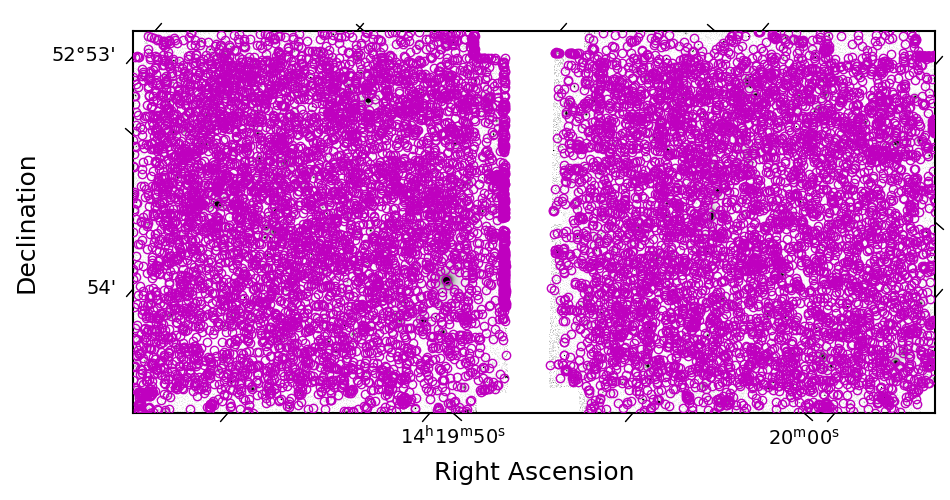

In [20]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(detection_catalog.data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(source_table['ra'], source_table['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

## Segmentation Map

<IPython.core.display.Javascript object>


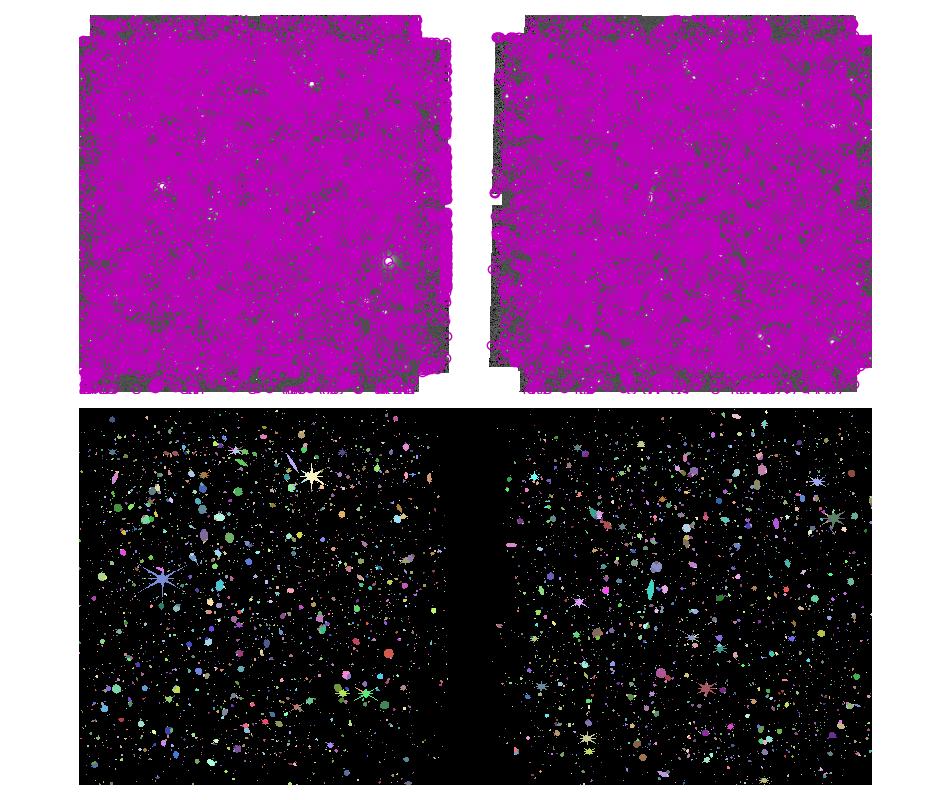

In [22]:
#fig, ax = plt.subplots(1, 2, figsize=(9.5,5), sharex=True, sharey=True)
fig, ax = plt.subplots(2, 1, figsize=(9.5, 8), sharex=True, sharey=True)

norm = simple_norm(detection_catalog.data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0].imshow(detection_catalog.data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[0].plot(source_table['x'], source_table['y'], 'mo', mfc='None')

cmap = detection_catalog.segm_deblend.make_cmap(seed=123)
ax[1].imshow(detection_catalog.segm_deblend, origin='lower', interpolation='none', cmap=cmap)

for ix in range(2):
    ax[ix].axis('off')